# CTD Data, Density & Buoyancy Frequency Calculator

Import formatted CTD data from La Perouse cruises, calculate in situ density, and find buoyancy frequency through depth.

Barkley Canyon centred at approximately Lat 48.33 Long -126.03, so CTD casts from station LB14 are closest (approximately Lat 48.1415 Long -126.0000 - a distance of about 21 km to the SE) and of sufficient depth (-1180 m).

Casts are every May and September.

Uses the Seawater Python package for determining ocean characteristics to calculate potential density, $\rho_{\theta}(z)$, and the Brünt-Väisälä Frequency squared ($N^2$(z)).

## Imports

In [1]:
# imports
import xarray as xr
import datetime
from datetime import datetime
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.dates as pldates
import numpy as np
import scipy.signal as sig
import scipy.interpolate as interp
import pandas as pd
import seawater as sea
from scipy.stats import chi2
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
for i in range(2):
    %matplotlib notebook

## CTD Data

La Perouse CTD data obtained from https://www.waterproperties.ca/data/display_results.php. 

In [173]:
year = '2018'        # strings for output filenames and titles
month = 'Sept'        # May or Sept

if month == 'May':
    name = 'May'
elif month == 'Sept':
    name = 'September'
    
ds = xr.open_dataset(f'/Users/Kurtis/Documents/Python/Data/LaPerouseLB14/{year}_{month}.nc')

## Density and $N^2$ Calculations

Density of Sea Water using UNESCO 1983 (EOS 80) polynomial.

Calculates potential density, and the Brünt-Väisälä Frequency squared ($N^2$), at the mid-depths (N2P), from the equation:
$N^{2} = \frac{-g}{\sigma_{\theta}} \frac{d\sigma_{\theta}}{dz}$

In [174]:
# calculate potential temp, potential density, and N2

P = ds.PRESPR01.values    # depth(pressure) [m]([dbar])
T = ds.TEMPS901.values    # temperature [Celsius]
S = ds.PSALST01.values    # salinity, PSS-78 [PSU]
lat = 48.14               # latitude, degrees North/South
pT = sea.eos80.ptmp(S,T,P,pr=0)                   # calculates potential temperature at P = 0
rho = sea.eos80.pden(S,T,P,pr=0)                  # calculates potential density of seawater at P = 0
N2_sea,q,N2P = sea.geostrophic.bfrq(S,T,P,lat)    # calculates squared Brunt-Vaisala frequency of seawater at mid-depths
N2 = N2_sea[:,0]
N2_avg_val = np.nanmean(N2[198:898])                  # average N^2 through depth (between -100m and -900m)
print('Average N^2, -200 m to -900 m = ',N2_avg_val,'(rad/s)^2')

if year == '2013' and month == 'May':
    N2_temp = pd.Series(N2)
    N2_int = N2_temp.interpolate(method="linear")
    N2 = np.array(N2_int)
    pT_temp = pd.Series(pT)
    pT_int = pT_temp.interpolate(method="linear")
    pT = np.array(pT_int)
    rho_temp = pd.Series(rho)
    rho_int = rho_temp.interpolate(method="linear")
    rho = np.array(rho_int)
    S_temp = pd.Series(S)
    S_int = S_temp.interpolate(method="linear")
    S = np.array(S_int)       # interpolate 3 metres of depth for May 2013
    
N2_smooth = sig.savgol_filter(N2,101,1)            # smooth with window size 51, poly order 3

np.save(f'N2_smooth_{year}_{month}',N2_smooth)

Average N^2, -200 m to -900 m =  1.0731113e-05 (rad/s)^2


## Comprehensive Plots

<IPython.core.display.Javascript object>


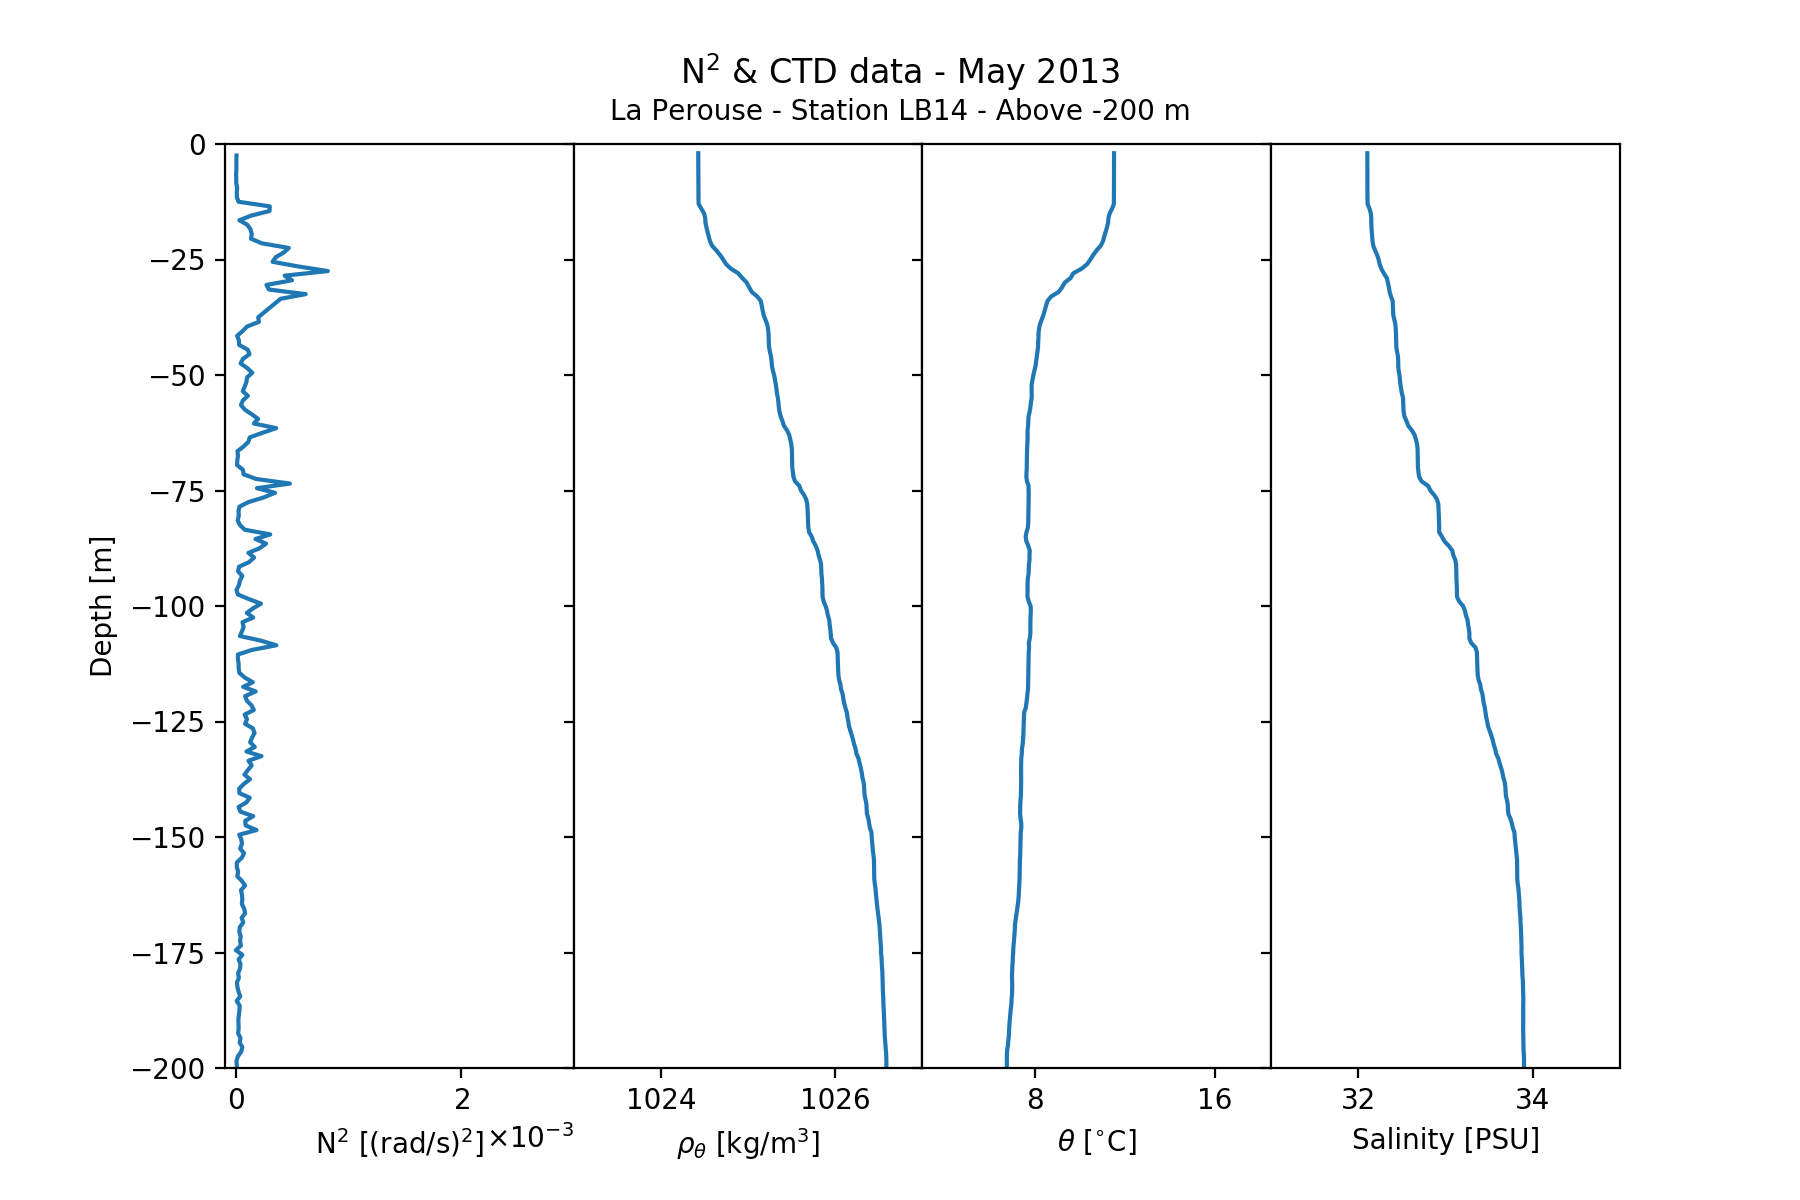

In [154]:
# plot N**2 and density through upper depth

fig, (ax0,ax1,ax2,ax3) = plt.subplots(1,4,figsize=(9,6),sharey=True)
fig.subplots_adjust(wspace=0.0)
ax0.plot(N2,-N2P)
ax0.set_ylabel('Depth [m]')
ax0.set_xlabel('N$^2$ [(rad/s)$^2$]')
ax0.ticklabel_format(axis='x', style='sci', scilimits=(0,0), useMathText=True)
ax0.set_xlim(-1e-4,3e-3)
ax0.xaxis.set_major_locator(plt.MaxNLocator(2))
ax1.plot(rho,-P)
ax1.set_xlabel('$\u03C1_\u03B8$ [kg/m$^3$]')
ax1.set_ylim(-200,0)
ax1.set_xlim(1023,1027)
ax1.xaxis.set_major_locator(plt.MaxNLocator(2))
ax2.plot(pT,-P)
ax2.set_xlabel('$\u03B8$ [$^{\circ}$C]')
ax2.set_xlim(3,18.5)
ax2.xaxis.set_major_locator(plt.MaxNLocator(2))
ax3.plot(S,-P)
ax3.set_xlabel('Salinity [PSU]')
ax3.set_xlim(31,35)
ax3.xaxis.set_major_locator(plt.MaxNLocator(2))
fig.text(0.5, 0.93, f'N$^2$ & CTD data - {name} {year}', ha='center', fontsize=12)
fig.text(0.5, 0.9, 'La Perouse - Station LB14 - Above -200 m', ha='center', fontsize=10)

plt.show()

plt.savefig(fname=f'../../plots/N2_plots/N2_upper_{month}_{year}.pdf',format='pdf')

<IPython.core.display.Javascript object>


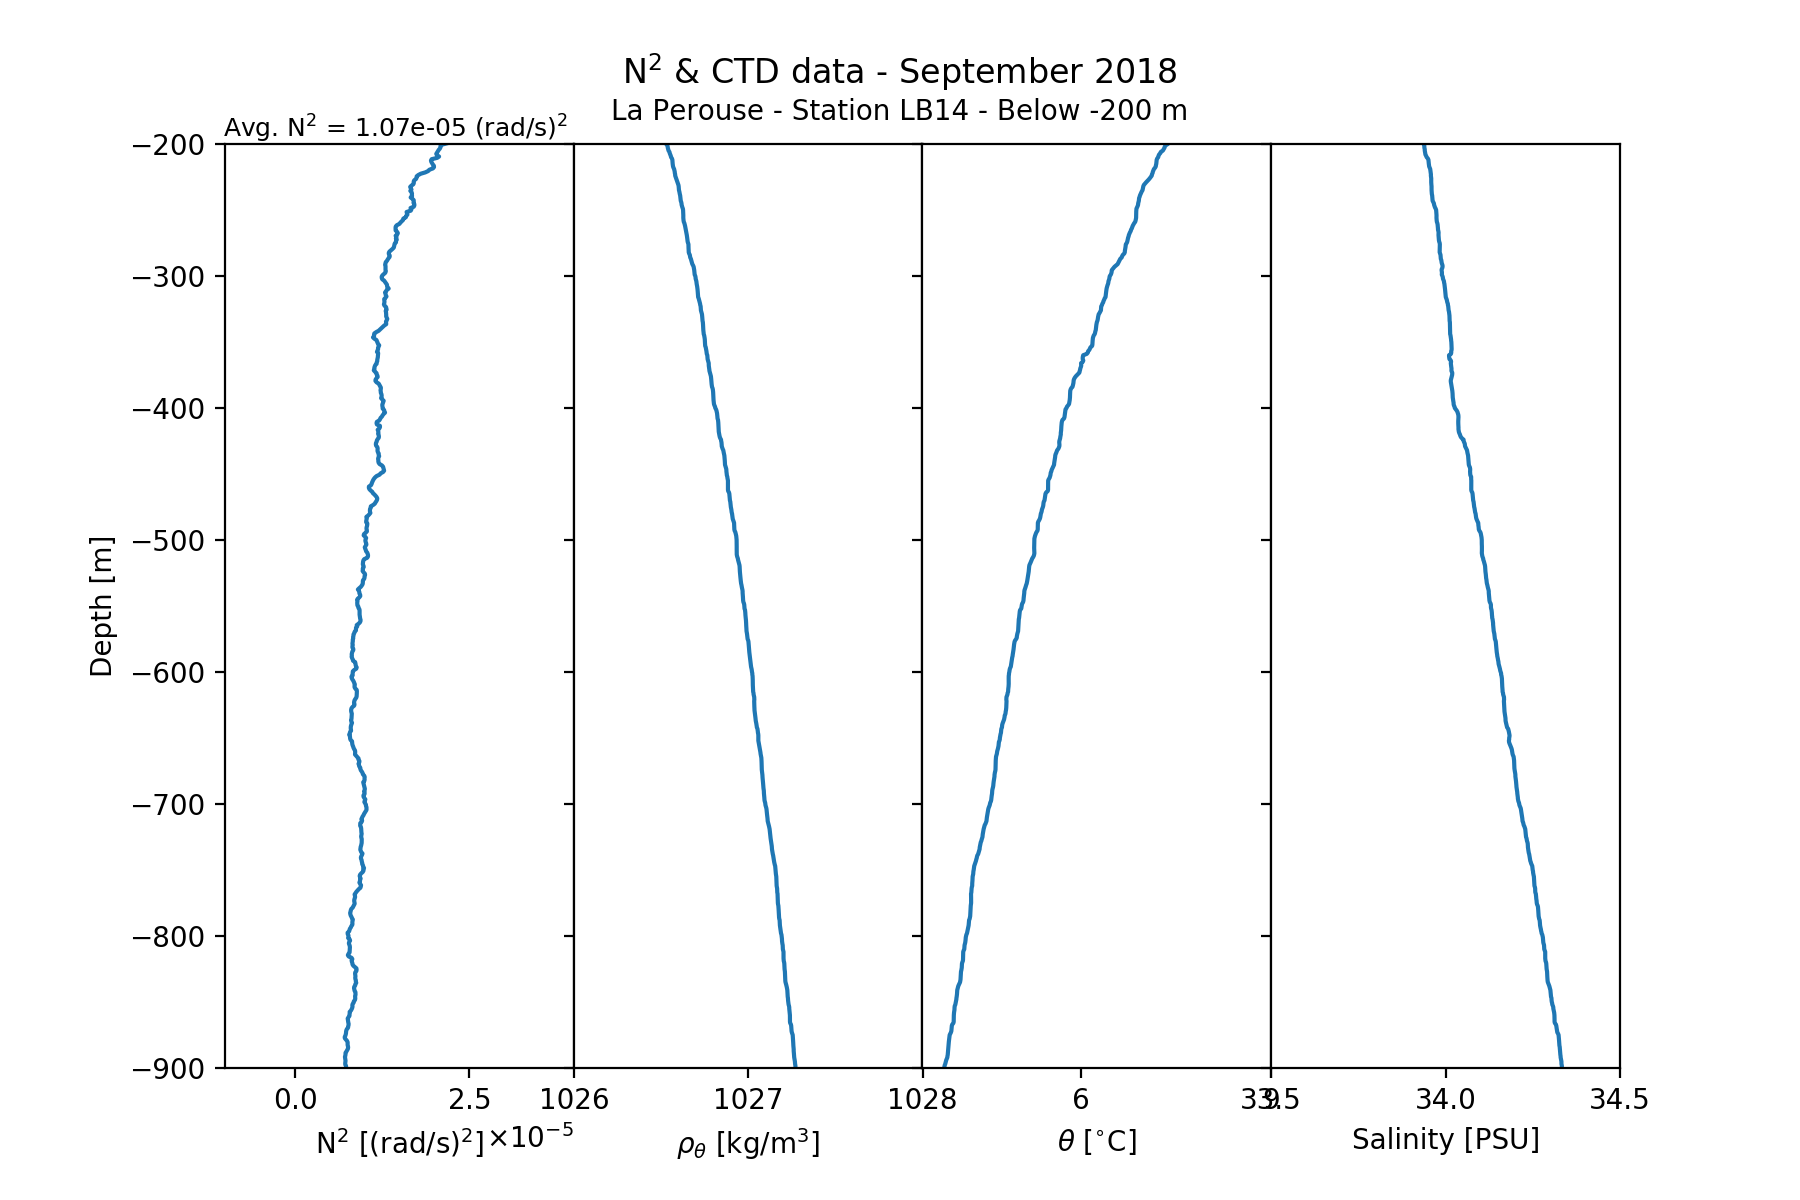

In [175]:
# plot N**2 and density through lower depth

fig, (ax0,ax1,ax2,ax3) = plt.subplots(1,4,figsize=(9,6),sharey=True)
fig.subplots_adjust(wspace=0.0)
ax0.plot(N2_smooth,-N2P)
ax0.set_ylabel('Depth [m]')
ax0.set_xlabel('N$^2$ [(rad/s)$^2$]')
ax0.ticklabel_format(axis='x', style='sci', scilimits=(0,0), useMathText=True)
ax0.set_xlim(-1e-5,4e-5)
ax0.xaxis.set_major_locator(plt.MaxNLocator(2))
ax1.plot(rho,-P)
ax1.set_xlabel('$\u03C1_\u03B8$ [kg/m$^3$]')
ax1.set_ylim(-900,-200)
ax1.set_xlim(1026,1028)
ax1.xaxis.set_major_locator(plt.MaxNLocator(2))
ax2.plot(pT,-P)
ax2.set_xlabel('$\u03B8$ [$^{\circ}$C]')
ax2.set_xlim(3.5,9)
ax2.xaxis.set_major_locator(plt.MaxNLocator(2))
ax3.plot(S,-P)
ax3.set_xlabel('Salinity [PSU]')
ax3.set_xlim(33.5,34.5)
ax3.xaxis.set_major_locator(plt.MaxNLocator(2))
fig.text(0.5, 0.93, f'N$^2$ & CTD data - {name} {year}', ha='center', fontsize=12)
fig.text(0.5, 0.9, 'La Perouse - Station LB14 - Below -200 m', ha='center', fontsize=10)
fig.text(0.22, 0.885, f'Avg. N$^2$ = {N2_avg_val:1.2e} (rad/s)$^2$', ha='center', fontsize=9)

plt.show()

plt.savefig(fname=f'../../plots/N2_plots/N2_lower_{month}_{year}.pdf',format='pdf')

## Averaged profile

Plot N$^2$ profile averaged for all four years, both seasons.

In [199]:
# load saved N2 profiles
May_2013 = np.load('N2_smooth_2013_May.npy')
Sept_2013 = np.load('N2_smooth_2013_Sept.npy')
May_2014 = np.load('N2_smooth_2014_May.npy')
Sept_2014 = np.load('N2_smooth_2014_Sept.npy')
May_2017 = np.load('N2_smooth_2017_May.npy')
Sept_2017 = np.load('N2_smooth_2017_Sept.npy')
May_2018 = np.load('N2_smooth_2018_May.npy')
Sept_2018 = np.load('N2_smooth_2018_Sept.npy')

In [200]:
# average saved N2 profiles
N2_avg = ( May_2013[2:899] + Sept_2013[0:897] + May_2014[3:900] + Sept_2014[2:899] +
    + May_2017[2:899] + Sept_2017[1:898] + May_2018[0:897] + Sept_2018[1:898] ) / 8 # average smoothed profiles
N2_avg_depths = np.arange(4,901,1)     # depth range
N2_avg_smooth = sig.savgol_filter(N2_avg,31,1)    # additional smoothing, if necessary

In [220]:
# determine depth-dependent scaling factor

N2_base = np.nanmean(N2_avg[888:898])         # average N^2 through depth (between -890m and -900m)
print('Average N^2 from -890 m to -900 m = ',N2_base,'(rad/s)^2')
scaling_depths = -N2_avg_depths[96:]
scaling = N2_avg_smooth[96:] / N2_base
array_tuple = (scaling_depths,scaling)
scaling_array = np.vstack(array_tuple)
np.save('scaling_array',scaling_array)

Average N^2 from -890 m to -900 m =  6.315783e-06 (rad/s)^2


<IPython.core.display.Javascript object>


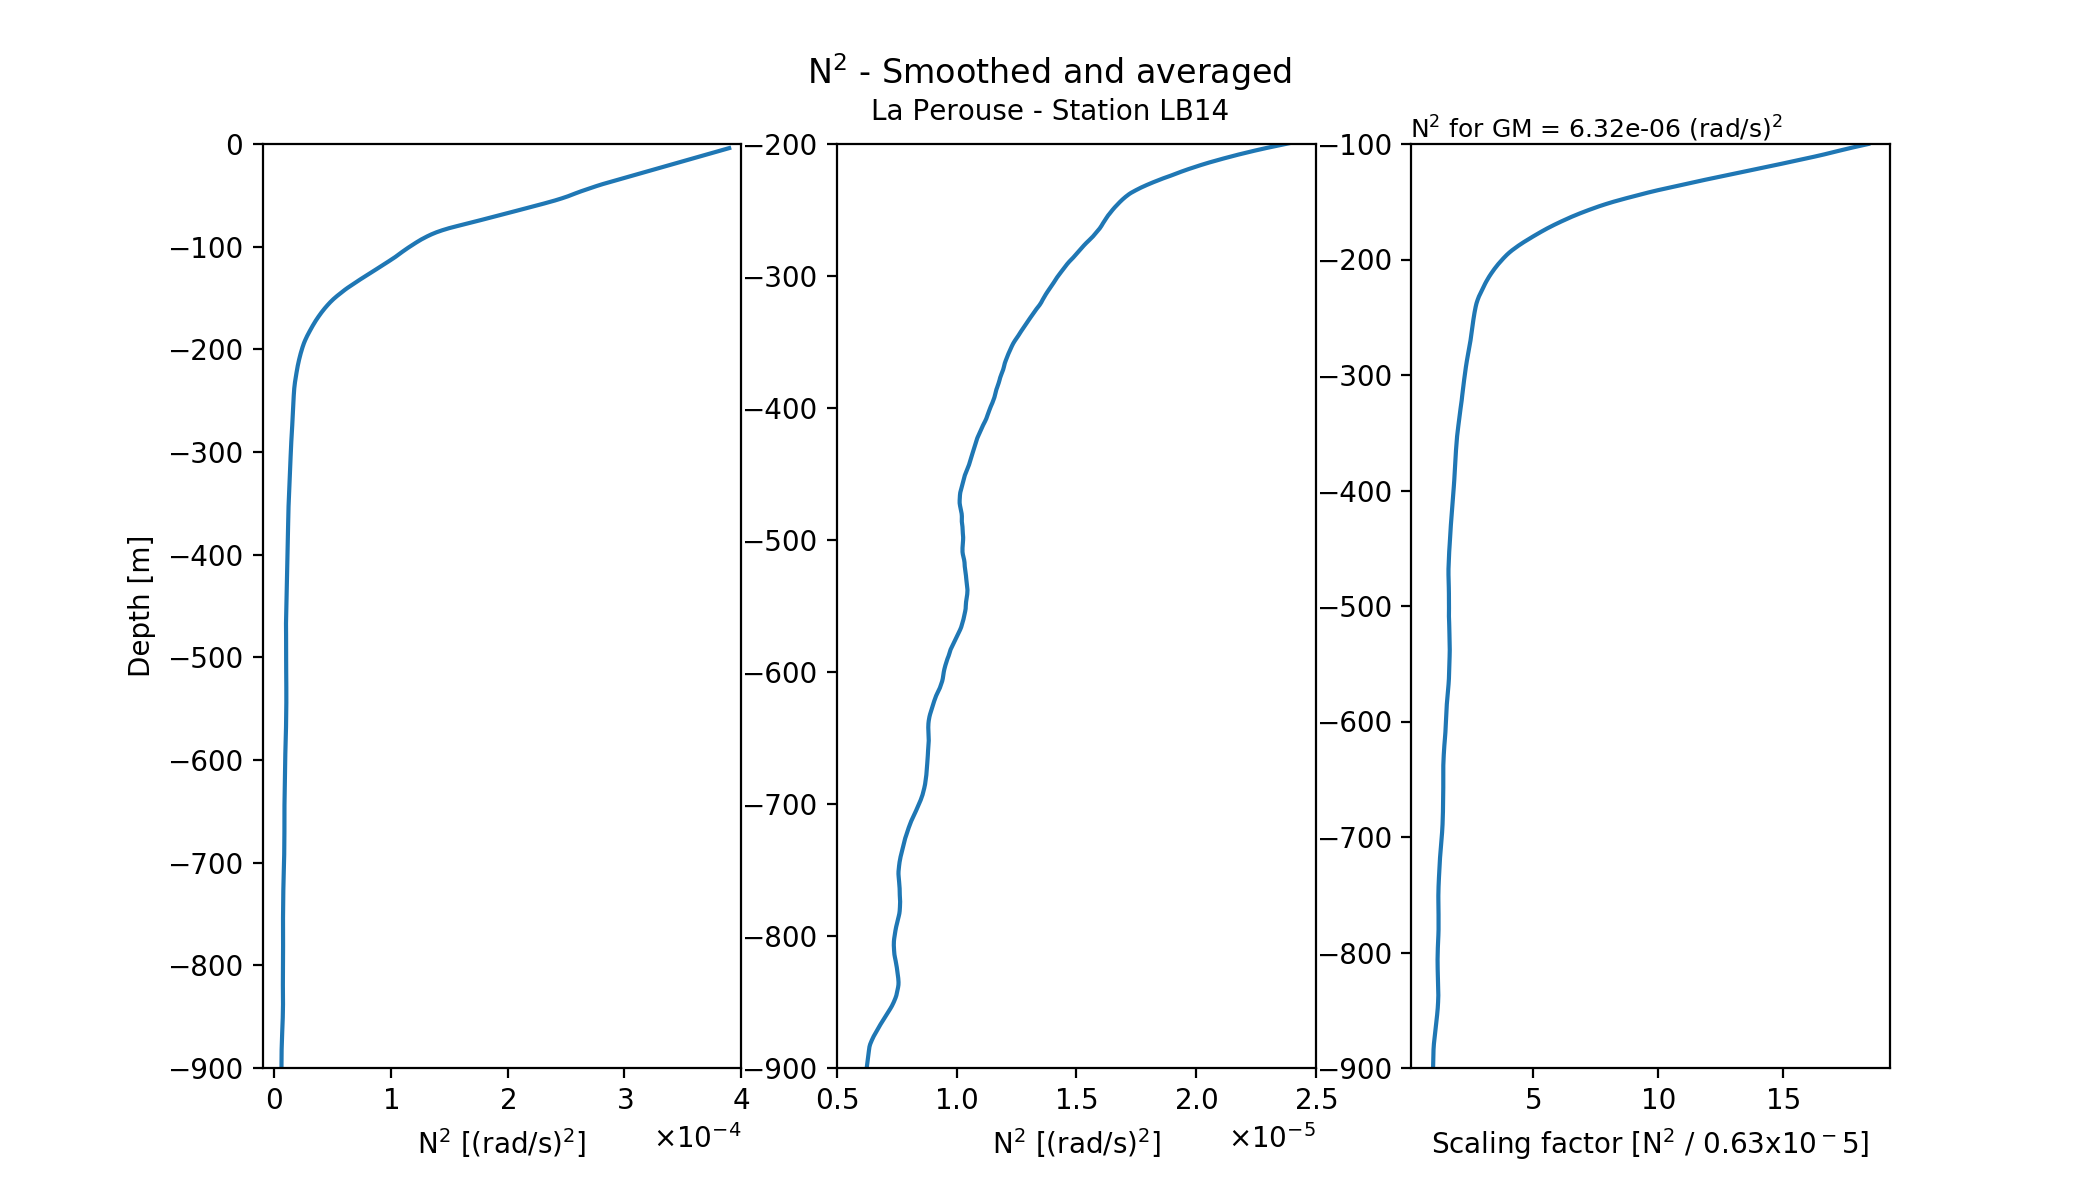

In [223]:
# plot N**2 and density through upper depth

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10.5,6))
ax1.plot(N2_avg_smooth,-N2_avg_depths)
ax1.set_xlabel('N$^2$ [(rad/s)$^2$]')
ax1.set_ylabel('Depth [m]')
ax1.ticklabel_format(axis='x', style='sci', scilimits=(0,0), useMathText=True)
ax1.set_xlim(-1e-5,0.4e-3)
ax1.set_ylim(-900,0)
ax2.plot(N2_avg_smooth,-N2_avg_depths)
ax2.set_xlabel('N$^2$ [(rad/s)$^2$]')
ax2.ticklabel_format(axis='x', style='sci', scilimits=(0,0), useMathText=True)
ax2.set_ylim(-900,-200)
ax2.set_xlim(5e-6,2.5e-5)
ax3.plot(scaling_array[1],scaling_array[0])
ax3.set_xlabel(f'Scaling factor [N$^2$ / 0.63x10$^-5$]')
ax3.set_ylim(-900,-100)

fig.text(0.5, 0.93, f'N$^2$ - Smoothed and averaged', ha='center', fontsize=12)
fig.text(0.5, 0.9, 'La Perouse - Station LB14', ha='center', fontsize=10)
fig.text(0.76, 0.885, f'N$^2$ for GM = {N2_base:1.2e} (rad/s)$^2$', ha='center', fontsize=9)

plt.show()

plt.savefig(fname=f'../../plots/N2_plots/N2_avg.pdf',format='pdf')